# European Options on SPX

## Overview

## Goals
- Define a function to calculate the price of a European Call using the Black-Scholes formula
    - We assume an interest rate and dividend yield equal to zero.
- Find the sensitivity in option value to change in the underlying, volatility and interest rate
    -Plot the sensitivities over time.
- Compute the daily PnL

### Getting the data

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from math import log, exp, sqrt

colnames=['Date','Close']
NOTEBOOK_ROOT = "~\Desktop\Project\Data"

df = pd.read_csv( os.path.join(NOTEBOOK_ROOT, "SPX.csv"), skiprows=1,names = colnames, index_col='Date', parse_dates=True)

In [2]:
df.head()

,Close
Date,
2015-01-01,2058.20
2015-01-05,2020.58
2015-01-06,2002.61
2015-01-07,2025.90
2015-01-08,2062.14


In [3]:
df.describe()

,Close
count,1072.000000
mean,2361.583116
std,303.062073
min,1829.080000
25%,2091.020000
50%,2339.880000
75%,2658.585000
max,2930.750000


In [4]:
days=len(df['2016-01-04' :'2019-01-04'])
print("Number of trading days during the life of the option= {}".format(days))

Number of trading days during the life of the option= 757


## 1. Black-Scholes formula for the pricing of European Calls

$C(S,t)$ is given below, where $S$ is the underlying, $K$ is the strike price, $r$ is the risk-free rate, q is the divend yield, T-t is the time to maturity and $\sigma$ is the (constant)  annualized volatility of the underlying.

\begin{equation}
	C(S, t)=  Se^{-q(T-t)} N(d_1) -  K  e^{-r(T-t)} N( d_2) 
\end{equation}

\begin{equation}
	d_1= \frac{\ln{\left(\frac{S}{K}\right)} + (T-t)\left(r -q + \frac{\sigma^2}{2} \right)}{\sigma \sqrt{T-t}} 
\end{equation}

\begin{equation}
	d_2= \frac{\ln{\left(\frac{S}{K}\right)} + (T-t)\left(r -q - \frac{\sigma^2}{2} \right)}{\sigma \sqrt{T-t}} 
\end{equation}

\begin{equation}
	N(x)=\frac{1}{\sqrt{2\pi}} \int_{-\infty}^{x} e^{-\frac{1}{2}z^2} dz
\end{equation}

**Black-Scholes and d1 functions.**

In [5]:
def d1(S,K,T,r,q,v):
    
    """ 
    Parameters
    ----------
    S -> Spot price
    K -> Strike price
    T-t -> Time to maturirty (assumme t=0)
    r -> Risk-free rate
    q -> Dividend yield
    v -> Volatility
           
    Returns
    --------
    Formula for d1
    
    """
    d= (log(S/K)+((r-q)+v*v/2)*T)/(v*sqrt(T))
    
    return d

In [6]:
def BS(Option,S,K,T,r,q,v):
    
    """ 
    Parameters
    ----------
    Option -> Call="c", otherwise, it is a Put
    S -> Spot price
    K -> Strike price
    T-t -> Time to maturirty (assumme t=0)
    r -> Risk-free rate
    q -> Dividend yield
    v -> Volatility
           
    Returns
    --------
    Price for a call or put vanilla option
    
    """
    
    d_1=d1(S,K,T,r,q,v)
    d_2=d_1-v*sqrt(T)
    if Option=='c':
        C=S*exp(-q*T)*norm.cdf(d_1)-K*exp(-r*T)*norm.cdf(d_2)
        return C
    else:
        P=K*exp(-r*T)*norm.cdf(-d_2)-S*exp(-q*T)*norm.cdf(-d_1)
        return P

Global variables

In [7]:
S=df.loc['2016-01-04', ["Close"]].iloc[0]
K=2500
T=days/252
r=0
q=0
v=0.2

In [8]:
print( '\033[1m' "S_0={}".format(S))

S_0=2012.66


In [9]:
Call=BS('c',S,K,T,r,q,v)
print('\033[1m' "Price of a European call={}".format(round(Call,3)))

Price of a European call=124.767


## 2. Greeks

### Delta

In [10]:
def delta(Option, S,K,T,r,q,v):
        
    """ 
    Parameters
    ----------
    Same as BS function
           
    Returns
    --------
    Delta for a call or put vanilla option
    
    """    
    d_1=d1(S,K,T,r,q,v)
    N_d1_call=norm.cdf(d_1)*exp(-q*T)
    N_d1_put=-norm.cdf(-d_1)*exp(-q*T)
    
    if Option=='c':
        return N_d1_call
    else:
        return N_d1_put

In [11]:
d=round(delta('c', S,K,T,r,q,v),3)
print('Delta= {}'. format(d))
print( '\033[1m Delta Hedging strategy if a portfolio manager sold call options:' 
      '\n Buy {} shares of the underlying stock now. Adjust the shares over time to maintain a delta-neutral portfolio.'.format(d))

Delta= 0.326
 Delta Hedging strategy if a portfolio manager sold call options:
 Buy 0.326 shares of the underlying stock now. Adjust the shares over time to maintain a delta-neutral portfolio.


### Gamma

In [12]:
def gamma(S,K,T,r,q,v):
        
    """ 
    Parameters
    ----------
    Same as BS function
           
    Returns
    --------
    Gamma for a European option
    
    """    
    d_1=d1(S,K,T,r,q,v)
    g=norm.pdf(d_1)*exp(-q*T)/(S*v*sqrt(T))
    
    return g

In [13]:
g=round(gamma(S,K,T,r,q,v),5)
print( 'Gamma= {}'. format(g))

Gamma= 0.00052


### Vega

In [14]:
def vega(S,K,T,r,q,v):  
    """ 
    Parameters
    ----------
    Same as BS function
           
    Returns
    --------
    Vega for a European option
    
    """    
    d_1=d1(S,K,T,r,q,v)
    v=norm.pdf(d_1)*S*sqrt(T)*exp(-q*T)
    
    return v

In [15]:
vg=round(vega(S,K,T,r,q,v),3)
print('Vega= {}'.format(vg))
print( '\033[1m' 'A 1% increase in volatility from 20% to 21% increases the value of the option by approximately {}'.format(vg*0.01))

Vega= 1256.385
A 1% increase in volatility from 20% to 21% increases the value of the option by approximately 12.56385


### Theta

In [16]:
def theta(Option, S,K,T,r,q,v):
    """ 
    Parameters
    ----------
    Same as BS function
           
    Returns
    --------
    Theta for a call or put vanilla option
    
    """    
    d_1=d1(S,K,T,r,q,v) 
    d_2 = d_1 - v * sqrt(T)
    
    if Option=='c':
        theta = -S * norm.pdf(d_1) * v *exp(-q*T)/ (2 * sqrt(T)) \
                 +q*S* norm.cdf(d_1)*exp(-q*T) \
                  - r * K * exp(-r*T) * norm.cdf(d_2)
        return theta
    
    else:
        theta = -S * norm.pdf(d_1) * v *exp(-q*T)/ (2 * sqrt(T)) \
                  -q*S* norm.cdf(-d_1)*exp(-q*T) \
                  +r * K * exp(-r*T) * norm.cdf(-d_2)
        return theta

In [17]:
th=round(theta('c', S,K,T,r,q,v),3)
print('Theta= {}'.format(th))
print( '\033[1m' 'Theta is equal to {} per trading day.'.format(th/252))

Theta= -41.824
Theta is equal to -0.16596825396825396 per trading day.


### Rho

In [18]:
def rho(Option, S,K,T,r,q,v):
    """ 
    Parameters
    ----------
    Same as BS function
           
    Returns
    --------
    Rho for a call or put vanilla option
    
    """    
    d_1=d1(S,K,T,r,q,v) 
    d_2 = d_1-v* sqrt(T)
    
    if Option=='c':
        rh=K*T*norm.cdf(d_2)*exp(-r*T)
        return rh
    
    else:
        rh=-K*T*exp(-r*T)*norm.cdf(-d_2)* exp(-r*T)
        return rh

In [19]:
rh=round(rho('c', S,K,T,r,q,v),3)
print('Rho= {}'.format(rh))
print( '\033[1m' 'A 1% increase in the interest rate increases the value of the option by approximately {}'.format(rh*0.01))

Rho= 1593.519
A 1% increase in the interest rate increases the value of the option by approximately 15.93519


### Option price and greeks over time

In [20]:
def plot_greeks(Time, Option):    
    
    """
    
    Parameters
    ----------
    Time -> Time to maturity
    Option -> Call="c", otherwise, it is a Put
    
    Returns
    --------
    Graph of option price, delta, gamma, theta, vega and rho over time
 
    """

    time=np.arange(0.001,3.001,0.001)
    bs= []
    dt=[]
    gm=[]
    vg=[]
    th=[]
    rh=[]
    for n in time:
        Call = BS(Option,S,K,n,r,q,v)
        Delta=delta(Option,S,K,n,r,q,v)
        Gamma=gamma(S,K,n,r,q,v)
        Vega=vega(S,K,n,r,q,v)*0.01
        Theta=theta(Option,S,K,n,r,q,v)/252
        Rho=rho(Option,S,K,n,r,q,v)*0.01
        bs.append(Call),dt.append(Delta), gm.append(Gamma), vg.append(Vega), th.append(Theta), rh.append(Rho)        
          
    # Create a figure
    fig = plt.figure(figsize=(14,7))
    _ = plt.subplots_adjust(wspace = 0.4, hspace = 0.6 )
    fig.suptitle('Option Price and Greeks over time', fontweight="bold")

    # Createa plot of price over time
    ax = fig.add_subplot(2, 3, 1)
    _ = ax.plot(time , bs, color="blue")
    _ = ax.set_title("Option price", fontweight="bold")
    _ = ax.set_xlabel("Time (years)"); _ = ax.set_ylabel("Option price")
    
    # Createa plot of delta over time
    ax = fig.add_subplot(2, 3, 2)
    _ = ax.plot(time, dt, color="blue")
    _ = ax.set_title("Delta", fontweight="bold")
    _ = ax.set_xlabel("Time (years)"); _ = ax.set_ylabel("Delta")
    
     # Createa plot of gamma over time
    ax = fig.add_subplot(2, 3, 3)
    _ = ax.plot(time , gm, color="blue")
    _ = ax.set_title("Gamma",fontweight="bold")
    _ = ax.set_xlabel("Time (years)"); _ = ax.set_ylabel("Gamma")

    # Createa plot of vega over time
    ax = fig.add_subplot(2, 3, 4)
    _ = ax.plot(time, vg, color="blue")
    _ = ax.set_title("Vega", fontweight="bold")
    _ = ax.set_xlabel("Time (years)"); _ = ax.set_ylabel("Vega")
    
    # Createa plot of theta over time
    ax = fig.add_subplot(2, 3, 5)
    _ = ax.plot(time, th, color="blue")
    _ = ax.set_title("Theta", fontweight="bold")
    _ = ax.set_xlabel("Time (years)"); _ = ax.set_ylabel("Theta")
    
    # Createa plot of rho over time
    ax = fig.add_subplot(2, 3, 6)
    _ = ax.plot(time, rh, color="blue")
    _ = ax.set_title("Rho", fontweight="bold")
    _ = ax.set_xlabel("Time (years)"); _ = ax.set_ylabel("Rho")
    
      
    return

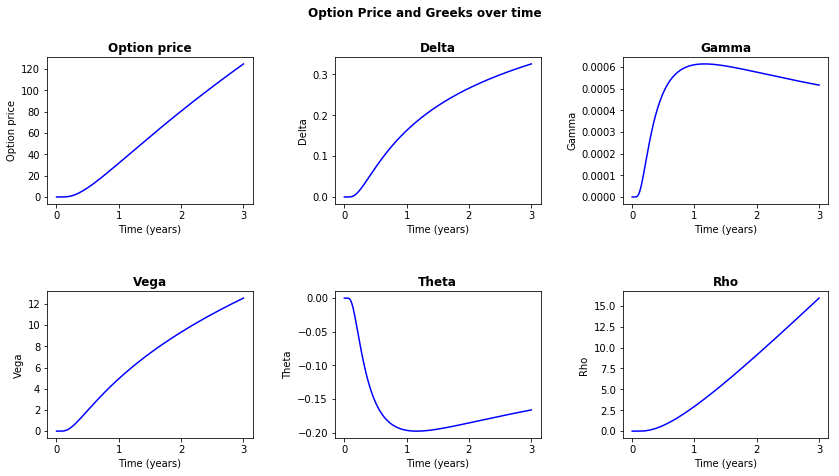

In [21]:
plot_greeks(3, 'c')

### Realized volatility

We can define realized volatility as:

\begin{equation}
	\sigma=\sqrt{ \frac{252}{n-2} \sum_{i=1}^{n-1} \left[ log \left({\frac{S_{i+1}}{S_i}}\right)\right] ^2}
\end{equation}

In the function below I used a percentage change function instead of a log function to calculate the realized volatility.

In [22]:
def rvol(df, ndays, date):
        
    """ 
    Parameters
    ----------
    df -> Dataframe
    ndays -> Number of days used to estimate realized volatility
    date -> String containing the date on which the realized volatility is calculated
   
    Returns
    --------
    Realized volatility
    
    """  
    pct= df.loc[:date]['Close'].tail(ndays).pct_change()
    pct=pct.dropna()
    pct=pct**2
    pct=pct.sum()
    vol=sqrt(pct*252/(ndays-2))  
    
    return vol

In [23]:
rv=round(rvol(df, 100, '2016-01-04' ),3)
print("Realized volatility= {}".format(rv))

Realized volatility= 0.199


### Option price using realized volatility

In [24]:
BS('c',S,K,T,r,q,rv)

123.51170786131513

In [25]:
diff=BS('c',S,K,T,r,q,v)-BS('c',S,K,T,r,q,rv)
print('\033[1m' 'Difference in the option price using static volatility and realized volatility={}'.format(diff))

Difference in the option price using static volatility and realized volatility=1.2552443507063344


## 3. Daily PnL

We can hedge by taking a stock position that offsets the option’s delta. For instance, **for a short call option, delta hedging means buying shares**. Because option deltas change as the stock price changes, portfolio managers must continually review and modify their hedging decisions. 

The daily PnL (delta hedge) is defined as:

\begin{equation}
    PnL_i=\Delta_{i-1}(S_i-S_{i-1})-(C_i-C_{i-1})-rB_{i-1}
\end{equation}

Where $\Delta_i$ denote the option delta on day i, $S_i$ the stock price, $C_i$ the option price, and $B_i=\Delta_{i}S_i-C_i$ is the market value of the portfolio.

The last expression is the overnight gain on shares, less the overnight gain on option, less interest owed (carrying cost of purchasing stocks). In the following function, we will assume r=0.

In [26]:
def PnL_dh(Option, v, df, num_cont, date1, date2):

    """ 
    Parameters
    ----------
    Option -> Call="c", otherwise, it is a Put
    v-> Volatility
    df -> Dataframe
    num_cont-> Number of contracts
    date1 -> Start date
    date2 -> End date
           
    Returns
    --------
    Daily PnL using delta hedging
    
    """    
    spot= df.loc[date1:date2]['Close'].values.tolist()
    num_days=len(df[date1:date2])
    ttm=list(range(1, num_days+1, 1))[::-1]
    
    dt=[] 
    bs=[]
    for a, b in zip(spot, ttm):
        Call = BS(Option,a,K,b/252,r,q,v)
        Delta=delta(Option,a,K,b/252,r,q,v)
        bs.append(Call), dt.append(Delta)
    df=df.loc[date1:date2].copy()
    df['BS'] = bs
    df['Delta'] = dt
    df['Delta_t-1']=df['Delta'].shift(1).fillna(0) 
    df['Price_chg']=df['Close'].diff().fillna(0) 
    df['BS_chg']=df['BS'].diff().fillna(0)
    df['PnL']= num_cont*(df['Price_chg']*df['Delta_t-1']- df['BS_chg'])
    
    return df

Accumulated PnL using static volatility= 88.24369666000693


Text(0.5, 0, 'Date')

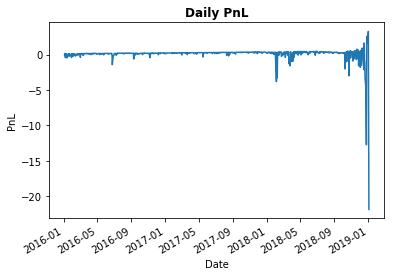

In [27]:
dh=PnL_dh('c', v, df,1, '2016-01-04', '2019-01-04')
PnL=dh['PnL'].sum()
print('\033[1m' 'Accumulated PnL using static volatility= {}'.format(PnL))
dh['PnL'].plot()
plt.title('Daily PnL', fontweight="bold" )
plt.ylabel("PnL")
plt.xlabel("Date")

Accumulated PnL using realized volatility= 86.06170907527792


Text(0.5, 0, 'Date')

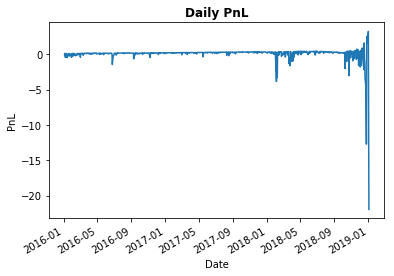

In [28]:
dh_2=PnL_dh('c', rv, df,1, '2016-01-04', '2019-01-04')
PnL=dh_2['PnL'].sum()
print('\033[1m' 'Accumulated PnL using realized volatility= {}'.format(PnL))
dh_2['PnL'].plot()
plt.title('Daily PnL', fontweight="bold" )
plt.ylabel("PnL")
plt.xlabel("Date")

In [34]:
dh.head(5)

,Close,BS,Delta,Delta_t-1,Price_chg,BS_chg,PnL
Date,,,,,,,
2016-01-04,2012.66,124.766952,0.325558,0.000000,0.00,0.000000,0.000000
2016-01-05,2016.71,125.922926,0.327461,0.325558,4.05,1.155974,0.162538
2016-01-06,1990.26,117.280357,0.313626,0.327461,-26.45,-8.642569,-0.018762
2016-01-07,1943.09,102.904701,0.289282,0.313626,-47.17,-14.375656,-0.418086
2016-01-08,1922.03,96.776858,0.278400,0.289282,-21.06,-6.127843,0.035554


In [30]:
dh.describe()

,Close,BS,Delta,Delta_t-1,Price_chg,BS_chg,PnL
count,757.000000,757.000000,757.000000,757.000000,757.000000,757.000000,757.000000
mean,2429.801691,217.373272,0.546546,0.545430,0.685971,-0.119187,0.116570
std,285.545909,91.245763,0.195693,0.196398,20.369905,13.028234,1.113923
min,1829.080000,1.492446,0.044058,0.000000,-113.190000,-86.330112,-21.864421
25%,2169.180000,142.435137,0.377828,0.377523,-5.910000,-3.087223,0.160475
50%,2435.610000,203.454194,0.505575,0.505038,1.000000,0.188072,0.239808
75%,2689.860000,282.513660,0.709420,0.708921,9.660000,4.450482,0.326273
max,2930.750000,444.859324,0.970556,0.970556,116.600000,55.183614,3.292995


### Daily PnL using Gamma and Theta

Clearly, delta, gamma, and theta all play a role in determining the profit on a delta-hedged position. Using Ito's lemma, we can get the Black-Scholes equation for a European call by solving the following PDE subject to boundary conditions:


\begin{equation}
	 \frac{\partial C}{\partial t} + \frac{1}{2}\sigma^2 s^2\frac{\partial^2 C}{\partial S^2}+rS\frac{\partial C}{\partial S}-rC=0
\end{equation}

We can apply this concept in discrete time to get PnL over a period of length h.

\begin{equation}
	PnL=\Delta_{t}(S_{t+h}-S_{t})-(C_{t+h}-C_{t})-rh(\Delta_t S_t -C_t)
\end{equation}

\begin{equation}
	PnL=\Delta_{t}(S_{t+h}-S_{t})-[\Delta_t(S_{t+h}-S_t)+\frac{1}{2}(S_{t+h}-S_t)^2 \Gamma_t + \theta_t h]-rh(\Delta_t S_t -C_t)
\end{equation}

\begin{equation}
	PnL=-h \Bigg ( \frac{1}{2} \sigma^2 S_t^2 \Gamma_t^2 + \theta_t +r \Big[ \Delta_t S_t -C_t \Big ]   \Bigg )
\end{equation}

In [31]:
def profit(Option, df, num_cont, date1, date2, h, v):

    """ 
    Parameters
    ----------
    Option -> Call="c", otherwise, it is a Put
    df -> Dataframe
    num_cont-> Number of contracts
    date1 -> Start date
    date2 -> End date
    h-> Period of length  h (1/252) 
           
    Returns
    --------
    Daily PnL using gamma and theta
    
    """    
    spot= df.loc[date1:date2]['Close'].values.tolist()
    num_days=len(df[date1:date2])
    ttm=list(range(1, num_days+1, 1))[::-1]
    
    gm=[] 
    th=[]
    for a, b in zip(spot, ttm):
        Gamma = gamma(a,K,b/252,r,q,v)
        Theta=theta(Option,a,K,b/252,r,q,v)
        gm.append(Gamma), th.append(Theta)
    df=df.loc[date1:date2].copy()
    df['Gamma'] = gm
    df['Theta'] = th
    df['PnL']= -num_cont*h*(0.5* v**2 * df['Close']**2 * df['Gamma'] + df['Theta'])
    
    return df

Accumulated PnL= -2.3741150139285885e-14


Text(0.5, 0, 'Date')

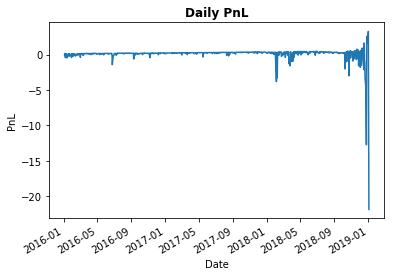

In [32]:
h=1/252
pf=profit('c',df,1, '2016-01-04', '2019-01-04', h, v)
PnL=pf['PnL'].sum()
print('Accumulated PnL= {}'.format(PnL))
dh['PnL'].plot()
plt.title('Daily PnL', fontweight="bold" )
plt.ylabel("PnL")
plt.xlabel("Date")

In [35]:
pf.head(5)

,Close,Gamma,Theta,PnL
Date,,,,
2016-01-04,2012.66,0.000516,-41.824166,-2.819614e-17
2016-01-05,2016.71,0.000517,-42.035604,-0.000000e+00
2016-01-06,1990.26,0.000515,-40.770136,-0.000000e+00
2016-01-07,1943.09,0.000509,-38.407366,-2.819614e-17
2016-01-08,1922.03,0.000505,-37.324788,-0.000000e+00


Now, I will use squared change in the stock price ($\epsilon^2$) instead of $\sigma^2 S_t^2$, the PnL equation becomes:
    
\begin{equation}
    PnL=-h \Bigg ( \frac{1}{2} \epsilon^2 \Gamma_t^2 + \theta_t +r \Big[ \Delta_t S_t -C_t \Big ]   \Bigg )
\end{equation}

The reason for this is because of the unrealistic assumption of the constant implied volatility over time.

## 4. Explaining results